In [117]:
import leaderbot as lb
import numpy as np
import pickle
import matplotlib.pyplot as plt
import matplotlib.ticker as mticker
from matplotlib.ticker import FuncFormatter
import texplot
from scipy.signal import savgol_filter

In [2]:
# Load form file instead
filename = '../benchmark/models_train_full.pkl'
# filename = '../benchmark/models_train_full_both_ties.pkl'
#filename = '../benchmark/models_train_split.pkl'
with open(filename, 'rb') as f:
    results = pickle.load(f)

models = results['models']
test_data = results['test_data']
test_data_no_tie = results['test_data_no_tie']
proc_time = np.array(results['proc_time'])
wall_time = np.array(results['wall_time'])

In [204]:
def plot_pred(ax, model, benchmark_model, rank, half_tie=False, 
              density=True, color='maroon', label=''):

    labelpad = 2

    # Cumulative count of observed data
    if model.__class__.__name__.startswith('BradleyTerry'):
        
        bn_p_wins, bn_p_losses, bn_p_ties = benchmark_model._cumulative_counts(density=True)
        bn_n_wins, bn_n_losses, bn_n_ties = benchmark_model._cumulative_counts(density=False)
        bn_n_matches = bn_n_wins + bn_n_losses + bn_n_ties
        
        x = np.copy(benchmark_model.x)
        y = np.copy(benchmark_model.y)

        x_alt = np.copy(benchmark_model.x)
        y_alt = np.copy(benchmark_model.y)
 
        y[:, 0] = y[:, 0] + 0.5 * y[:, 2]
        y[:, 1] = y[:, 1] + 0.5 * y[:, 2]
  
        y_alt[:, 0] = y_alt[:, 0] + 0.5 * y_alt[:, 2]
        y_alt[:, 1] = y_alt[:, 1] + 0.5 * y_alt[:, 2]
        y_alt[:, 2] = 0

        # Cumulative count of observed data
        p_wins, p_losses, p_ties = model._cumulative_counts(x, y, density=True)
        p_wins_alt, p_losses_alt, p_ties_alt = model._cumulative_counts(x_alt, y_alt, density=True)
        n_wins, n_losses, n_ties = model._cumulative_counts(x, y, density=False)
        n_matches = n_wins + n_losses + n_ties

    else:
        # Cumulative count of observed data
        p_wins, p_losses, p_ties = model._cumulative_counts(density=True)
        n_wins, n_losses, n_ties = model._cumulative_counts(density=False)
        n_matches = n_wins + n_losses + n_ties
        
    # Predicted outcome
    prob = model.infer()

    n_pred = np.sum(model.y, axis=1, keepdims=True) * prob
    p_wins_pred, p_losses_pred, p_ties_pred = \
        model._cumulative_counts(model.x, n_pred, density=True)

    n_wins_pred, n_losses_pred, n_ties_pred = \
        model._cumulative_counts(model.x, n_pred, density=False)

    # Which quantity to plot
    if density:
        # Probabilities
        q_wins = 100.0 * p_wins
        q_losses = 100.0 * p_losses

        if model.__class__.__name__.startswith('BradleyTerry'):
            q_ties = 100.0 * bn_p_ties
        else:
            q_ties = 100.0 * p_ties

        q_wins_pred = 100.0 * p_wins_pred
        q_losses_pred = 100.0 * p_losses_pred
        q_ties_pred = 100.0 * p_ties_pred
    else:
        # Frequencies
        q_wins = n_wins
        q_losses = n_losses
        q_ties = n_ties

        q_wins_pred = n_wins_pred
        q_losses_pred = n_losses_pred
        q_ties_pred = n_ties_pred

    rng = np.arange(1, 1+rank.size)

    # First plot row: frequencies
    label_obs = 'Observed Data'
    label_obs_alt = 'Obsreved Data (Modified)'
    label_pred = 'Model Prediction'
    
    ax[0].plot(rng, q_wins[rank], color='black', label=label_obs)
    ax[1].plot(rng, q_losses[rank], color='black', label=label_obs)
    ax[2].plot(rng, q_ties[rank], color='black', label=label_obs)
    
    if model.__class__.__name__.startswith('BradleyTerry'):
        ax[0].plot(rng, 100.0 * p_wins_alt[rank], ':', color='black', label=label_obs_alt)
        ax[1].plot(rng, 100.0 * p_losses_alt[rank], ':', color='black', label=label_obs_alt)
        ax[2].plot(rng, 100.0 * p_ties_alt[rank], ':', color='black', label=label_obs_alt)

    ax[0].plot(rng, q_wins_pred[rank], color=color, label=label_pred)
    ax[1].plot(rng, q_losses_pred[rank], color=color, label=label_pred)
    ax[2].plot(rng, q_ties_pred[rank], color=color, label=label_pred)
        
    ax[0].set_ylim([0, 80])
    ax[1].set_ylim([0, 80])
    ax[2].set_ylim([0, 30])

    ax[0].set_yticks([0, 40, 80])
    ax[1].set_yticks([0, 40, 80])
    ax[2].set_yticks([0, 15, 30])

    for j in range(3):

        ax[j].set_xticks([1, 40, 80, rank.size])

        if j == 2:
            ax[j].legend(fontsize='x-small', labelspacing=0.2)
        ax[j].set_xlim([rng[0], rng[-1]])
        #ax[j].set_xlabel('Rank')

        if j == 0:
            if density:
                #ax[j].set_ylim(top=100)
                ax[j].set_ylabel('Probability', labelpad=labelpad)
            else:
                ax[j].set_ylabel('Frequency', labelpad=labelpad)

        if not density:
            # Format y axis to use 10k labels instead of 10000
            ax[j].yaxis.set_major_formatter(mticker.FuncFormatter(
                lambda x, _: f'{int(x/1000)}k'))

        # Format y axis to use percent
        if density:
            ax[j].yaxis.set_major_formatter(
                mticker.PercentFormatter(decimals=0))

    ax[0].set_title('Win' + f' ({label})')
    ax[1].set_title('Loss' + f' ({label})')
    ax[2].set_title('Tie' + f' ({label})')

In [241]:
def y_formatter(val, pos):
    return f'$10^{{{int(np.log10(val))}}}$\%'

def plot_pred_err(ax, model, benchmark_model, rank, half_tie=False,
                  density=True, color='black', label='', log=True):

    labelpad = 0.1

    # Cumulative count of observed data
    if model.__class__.__name__.startswith('BradleyTerry'):
        
        # bn_p_wins, bn_p_losses, bn_p_ties = benchmark_model._cumulative_counts(density=True)
        # bn_n_wins, bn_n_losses, bn_n_ties = benchmark_model._cumulative_counts(density=False)
        # bn_n_matches = bn_n_wins + bn_n_losses + bn_n_ties
        
        x = np.copy(benchmark_model.x)
        y = np.copy(benchmark_model.y)

        # x_alt = np.copy(model.x)
        # y_alt = np.copy(model.y)

        if half_tie:
            y[:, 0] = y[:, 0] + 0.5 * y[:, 2]
            y[:, 1] = y[:, 1] + 0.5 * y[:, 2]
            y[:, 2] = 0
        else:
            y[:, 2] = 0
  
        # y_alt[:, 0] = y_alt[:, 0] + 0.5 * y_alt[:, 2]
        # y_alt[:, 1] = y_alt[:, 1] + 0.5 * y_alt[:, 2]
        # y_alt[:, 2] = 0

        # Cumulative count of observed data
        p_wins, p_losses, p_ties = model._cumulative_counts(x, y, density=True)
        # p_wins_alt, p_losses_alt, p_ties_alt = model._cumulative_counts(x_alt, y_alt, density=True)
        n_wins, n_losses, n_ties = model._cumulative_counts(x, y, density=False)
        n_matches = n_wins + n_losses + n_ties

    else:
        # Cumulative count of observed data
        p_wins, p_losses, p_ties = model._cumulative_counts(density=True)
        n_wins, n_losses, n_ties = model._cumulative_counts(density=False)
        n_matches = n_wins + n_losses + n_ties

    # Predicted outcome
    prob = model.infer()

    n_pred = np.sum(model.y, axis=1, keepdims=True) * prob
    p_wins_pred, p_losses_pred, p_ties_pred = \
        model._cumulative_counts(model.x, n_pred, density=True)

    n_wins_pred, n_losses_pred, n_ties_pred = \
        model._cumulative_counts(model.x, n_pred, density=False)

    # Which quantity to plot
    if density:
        # Probabilities
        q_wins = 100.0 * p_wins
        q_losses = 100.0 * p_losses
        q_ties = 100.0 * p_ties

        q_wins_pred = 100.0 * p_wins_pred
        q_losses_pred = 100.0 * p_losses_pred
        q_ties_pred = 100.0 * p_ties_pred
    else:
        # Frequencies
        q_wins = n_wins
        q_losses = n_losses
        q_ties = n_ties

        q_wins_pred = n_wins_pred
        q_losses_pred = n_losses_pred
        q_ties_pred = n_ties_pred

    rng = np.arange(1, 1+rank.size)
    
    err_q_wins = 100.0 * np.abs(1.0 - q_wins_pred[rank] / q_wins[rank])
    err_q_losses = 100.0 * np.abs(1.0 - q_losses_pred[rank] / q_losses[rank])
    err_q_ties = 100.0 * np.abs(1.0 - q_ties_pred[rank] / q_ties[rank])

    # if model.__class__.__name__.startswith('BradleyTerry'):
    #     err_q_wins_alt = 100.0 * np.abs(1.0 - q_wins_pred[rank] / p_wins_alt[rank])
    #     err_q_losses_alt = 100.0 * np.abs(1.0 - q_losses_pred[rank] / p_losses_alt[rank])
    #     err_q_ties_alt = 100.0 * np.abs(1.0 - q_ties_pred[rank] / p_ties_alt[rank])

    window = 3
    order = 1
    err_q_wins = savgol_filter(err_q_wins, window_length=window, polyorder=order)
    err_q_losses = savgol_filter(err_q_losses, window_length=window, polyorder=order)
    err_q_ties = savgol_filter(err_q_ties, window_length=window, polyorder=order)

    # err_q_wins = np.abs(q_wins_pred[rank] - q_wins[rank])
    # err_q_losses = np.abs(q_losses_pred[rank] - q_losses[rank])
    # err_q_ties = np.abs(q_ties_pred[rank] - q_ties[rank])

    if model.__class__.__name__.startswith('BradleyTerry'):
        # label_alt = label + ' (w.r.t Modifed Data)'
        label = label + ' (w.r.t Modfied Data)'

    ax[0].plot(rng, err_q_wins, color=color, label=label)
    ax[1].plot(rng, err_q_losses, color=color, label=label)
    ax[2].plot(rng, err_q_ties, color=color, label=label)

    # if model.__class__.__name__.startswith('BradleyTerry'):
    #     ax[0].plot(rng, 100.0 * p_wins_alt[rank], ':', color=color, label=label_alt)
    #     ax[1].plot(rng, 100.0 * p_losses_alt[rank], ':', color=color, label=label_alt)
    #     ax[2].plot(rng, 100.0 * p_ties_alt[rank], ':', color=color, label=label_alt)

    for j in range(3):

        ax[j].set_xticks([1, 40, 80, rank.size])

        if log:
            ax[j].set_yscale('log')

        if j == 2:
            ax[j].legend(fontsize='x-small', framealpha=0.9, loc='lower center', labelspacing=0.5)
        ax[j].set_xlim([rng[0], rng[-1]])
        #ax[j].set_ylim(bottom=0)
        ax[j].set_xlabel('Rank')

        if j == 0:
            if density:
                #ax[j].set_ylim(top=100)
                ax[j].set_ylabel('Relative Error of Probability', labelpad=labelpad)
            else:
                ax[j].set_ylabel('Frequency', labelpad=labelpad)

        # Format y axis to use percent
        if density:
            # ax[j].yaxis.set_major_formatter(
            #     mticker.PercentFormatter(decimals=0))
            if log:
                ax[j].yaxis.set_major_formatter(FuncFormatter(y_formatter))
            else:
                ax[j].set_ylim([0, 50])

        else:
            # Format y axis to use 10k labels instead of 10000
            ax[j].yaxis.set_major_formatter(mticker.FuncFormatter(
                lambda x, _: f'{int(x/1000)}k'))

    # ax[0].set_ylim([1e-3, 2e+1])
    # ax[1].set_ylim([1e-3, 2e+1])
    # ax[2].set_ylim([1e-2, 1e+2])

    ax[0].set_ylim([1e-3, 1e+2])
    ax[1].set_ylim([1e-3, 1e+2])
    ax[2].set_ylim([1e-3, 1e+2])

    ax[0].tick_params(axis='y', pad=2)
    ax[1].tick_params(axis='y', pad=2)
    ax[2].tick_params(axis='y', pad=2)

    ax[0].set_title('Win (All Models Above)')
    ax[1].set_title('Loss (All Models Above)')
    ax[2].set_title('Tie (All Models Above)')

Plot saved to "/home/sia/work/github/arenaranking/notebooks/predictions_error.svg".
Plot saved to "/home/sia/work/github/arenaranking/notebooks/predictions_error.pdf".


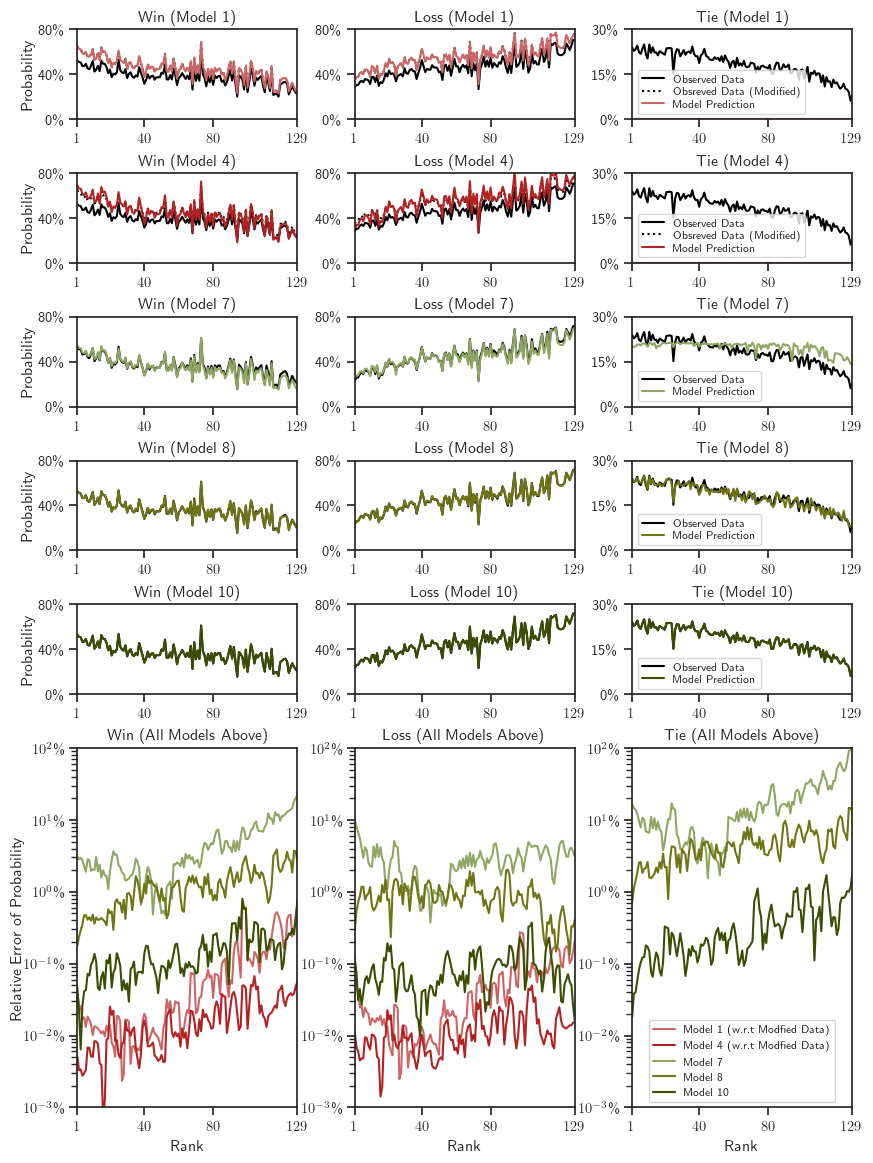

In [242]:
latex = True
save = True
density = True

benchmark_model = models[29]
score = benchmark_model.param[:benchmark_model.n_agents]
rank = np.argsort(score)[::-1]

#model_orders = np.array([30, 18, 26, 14, 22, 10, 6, 3, 19, 7, 4, 1]) - 1
#model_orders = np.array([1, 7, 19, 18, 30]) - 1
model_orders = np.array([1, 4, 7, 8, 10]) - 1
# colors = [
#     'maroon',
#     'green',
#     'royalblue',
#     'darkgoldenrod',
#     'olive']

colors = [
    #'coral',
    #'maroon',
    #'orangered',
    #'firebrick',
    #'#E57373', '#B22222',
    #'#E57373', '#B22222',
    '#CC6666', '#B22222',
    #'#b3c677', '#808000', '#556b2f',
    #'#a0b763', '#6e7513', '#3b4d00',
    #'#91a55d', '#6e7513', '#3b4d00',
    '#8FA763', '#6E7513', '#3B4D00',
    #'darkkhaki',
    #'olive',
    #'darkolivegreen',
    #'darkgreen'
]

with texplot.theme(rc={'font.family': 'sans-serif'}, use_latex=latex, font_scale=0.95):
    
    fig, ax = plt.subplots(nrows=model_orders.size+1, ncols=3, figsize=(10, 14),
                           gridspec_kw={'height_ratios': [1, 1, 1, 1, 1, 4],
                                         'hspace': 0.4, 'wspace': 0.26})

    ax = np.array(ax)

    for i in range(model_orders.size):

        if model_orders[i] == 0:
            half_tie = True
        else:
            half_tie = False
        
        plot_pred(ax[i], models[model_orders[i]], benchmark_model, rank, half_tie=half_tie,
                  density=density, color=colors[i], label=f'Model {model_orders[i]+1}')
        
        plot_pred_err(ax[-1], models[model_orders[i]], benchmark_model, rank, half_tie=half_tie,
                      density=density, color=colors[i],
                      label=f'Model {model_orders[i]+1}', log=True)
    
    plt.tight_layout()
    
    texplot.show_or_save_plot(plt, default_filename='predictions_error',
                              transparent_background=False,
                              dpi=200, show_and_save=save,
                              verbose=True)